In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path('../../src')))

from synthetic import (
    compute_area_planform, downstream_link,
    solve_advection_diffusion_planform,
    solve_advection_diffusion_planform_noflux,
    inlet_area_from_Pe, D_from_Pe, Pe_from_D_Ain,
    A_top_for_target_inlet_area,
    channel_slope_centerline,
    laplacian_2d, interior_slice, interior_slice_indices,
)
from analysis import fit_slope_area, ks_local_from_SA
from plotting import set_nature_style

[primary] Pe_bal=100, L_PE=50 m -> D_bal=4.402e-02, A_inlet_bal=2.590e+08
[primary] factor=1 -> D=4.402e-02, Pe=100


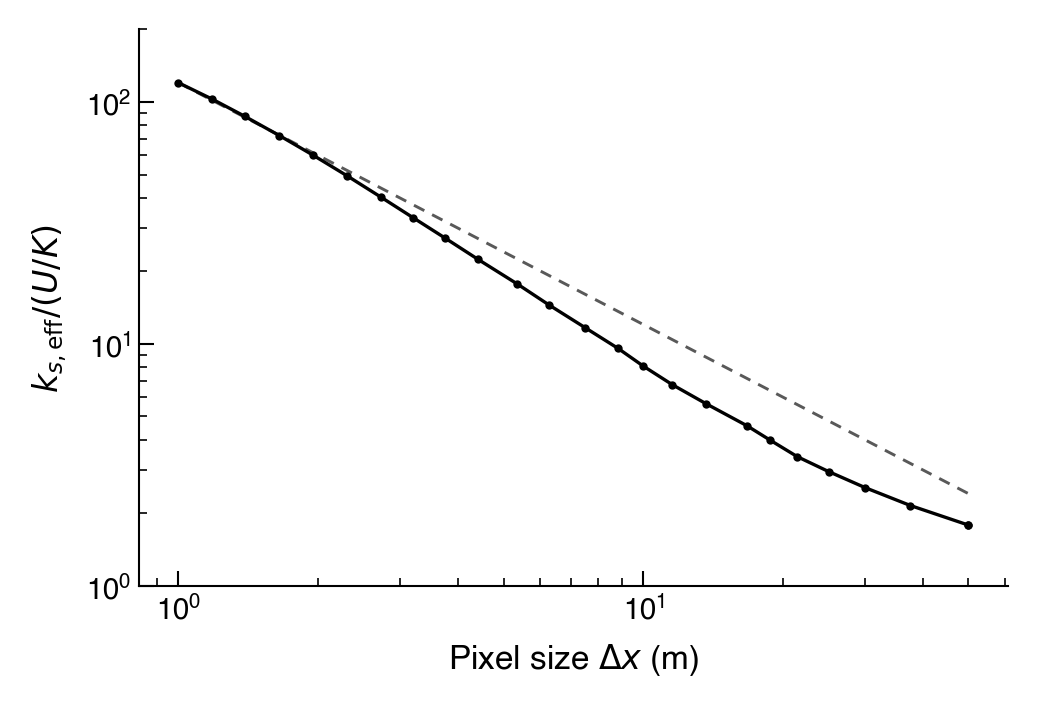

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator

# -----------------------
# USER PARAMS
# -----------------------
Lx, Ly = 300.0, 200.0
U = 1.47e-4
K = 1E-4
m = 0.35

L_PE = 50.0
PE_BAL = 100.0

BASELINE_MODE = "A_INLET"   # "A_INLET" or "D"
A_INLET_BAL_ANCHOR = 2.59E8
D_BAL_ANCHOR       = 4.4E-2

dx_targets = np.logspace(np.log10(55.0), np.log10(1.0), 25)[::-1]
FRAC_TRIM = 0.00

# ONLY compute this curve:
PRIMARY_FACTOR = 1.0

# Reference scale
ks_ref = U / K

# -----------------------
# Matplotlib style
# -----------------------
set_nature_style()

# ============================================================
# Compute curve for fixed A_inlet_target and chosen D
# ============================================================

def compute_curve_fixed_Ain(D_use, A_inlet_target):
    dx_list, ks_list = [], []

    for dx_t in dx_targets:
        Nx = int(round(Lx / dx_t)) + 1
        Ny = int(round(Ly / dx_t)) + 1
        if Nx % 2 == 0:
            Nx += 1

        A_top_use = A_top_for_target_inlet_area(Nx, Ny, Lx, Ly, A_inlet_target)
        Z, A, dx, dy = solve_advection_diffusion_planform(U, K, m, D_use, Nx, Ny, Lx, Ly, A_top_use)

        ic = (Nx - 1) // 2
        sl = interior_slice(Ny, FRAC_TRIM)

        lap = laplacian_2d(Z, dx, dy)[:, ic]
        ks_eff = ks_ref + (D_use / K) * lap
        ks_med = float(np.nanmedian(ks_eff[sl]))
        ks_norm = ks_med / ks_ref

        if np.isfinite(dx) and dx > 0 and np.isfinite(ks_norm) and ks_norm > 0:
            dx_list.append(dx)
            ks_list.append(ks_norm)

    dx_arr = np.array(dx_list)
    ks_arr = np.array(ks_list)
    order = np.argsort(dx_arr)  # finest first
    return dx_arr[order], ks_arr[order]

# ============================================================
# 1) Peclet-consistent baseline
# ============================================================

if BASELINE_MODE.upper() == "A_INLET":
    A_inlet_bal = float(A_INLET_BAL_ANCHOR)
    D_bal = D_from_Pe(PE_BAL, A_inlet_bal, K, L_PE, m)
elif BASELINE_MODE.upper() == "D":
    D_bal = float(D_BAL_ANCHOR)
    A_inlet_bal = inlet_area_from_Pe(PE_BAL, D_bal, K, L_PE, m)
else:
    raise ValueError("BASELINE_MODE must be 'A_INLET' or 'D'.")

D_primary = D_bal * PRIMARY_FACTOR
Pe_primary = Pe_from_D_Ain(D_primary, A_inlet_bal, K, L_PE, m)

print(f"[primary] Pe_bal={PE_BAL:g}, L_PE={L_PE:g} m -> "
      f"D_bal={D_bal:.3e}, A_inlet_bal={A_inlet_bal:.3e}")
print(f"[primary] factor={PRIMARY_FACTOR:g} -> D={D_primary:.3e}, Pe={Pe_primary:.3g}")

# ============================================================
# 2) Compute curve
# ============================================================

dx_arr, ks_arr = compute_curve_fixed_Ain(D_use=D_primary, A_inlet_target=A_inlet_bal)
if len(dx_arr) == 0:
    raise RuntimeError("Primary curve is empty. Check parameters or solver stability.")

# ============================================================
# Plot:  Curve  (dots + thin line + -1 slope guide)
# ============================================================

fig, ax = plt.subplots(figsize=(3.5, 2.4))

# Primary curve: small dots + thin connecting line
ax.plot(
    dx_arr,
    ks_arr,
    "-o",
    color="0.0",
    lw=0.8,
    ms=2.0,
    mfc="0.0",
    mec="0.0",
    mew=0.0,
    zorder=3,
)

# -1 slope reference line (anchored to finest-resolution point)
dx0 = dx_arr[0]
ks0 = ks_arr[0]
dx_ref = np.array([dx_arr.min(), dx_arr.max()])
ks_ref_line = ks0 * (dx_ref / dx0) ** (-1.0)

ax.plot(
    dx_ref,
    ks_ref_line,
    "--",
    color="0.35",
    lw=0.7,
    dashes=(4, 3),
    zorder=1,
)

# Axes
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"Pixel size $\Delta x$ (m)")
ax.set_ylabel(r"$k_{s,\mathrm{eff}}/(U/K)$")

ax.set_ylim(1e-0, 2e2)



# Nature-style cleanup
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.xaxis.set_major_locator(LogLocator(base=10))
ax.yaxis.set_major_locator(LogLocator(base=10))
ax.tick_params(which="both", pad=2)

fig.tight_layout()

# Vector-safe export (recommended)
# fig.savefig("ks_vs_dx_primary.pdf")
# fig.savefig("ks_vs_dx_primary.svg", transparent=True)

plt.show()

[primary] Pe_bal=100, L_PE=50 m -> D_bal=4.402e-02, A_inlet_bal=2.590e+08
[primary] factor=1 -> D=4.402e-02, Pe=100


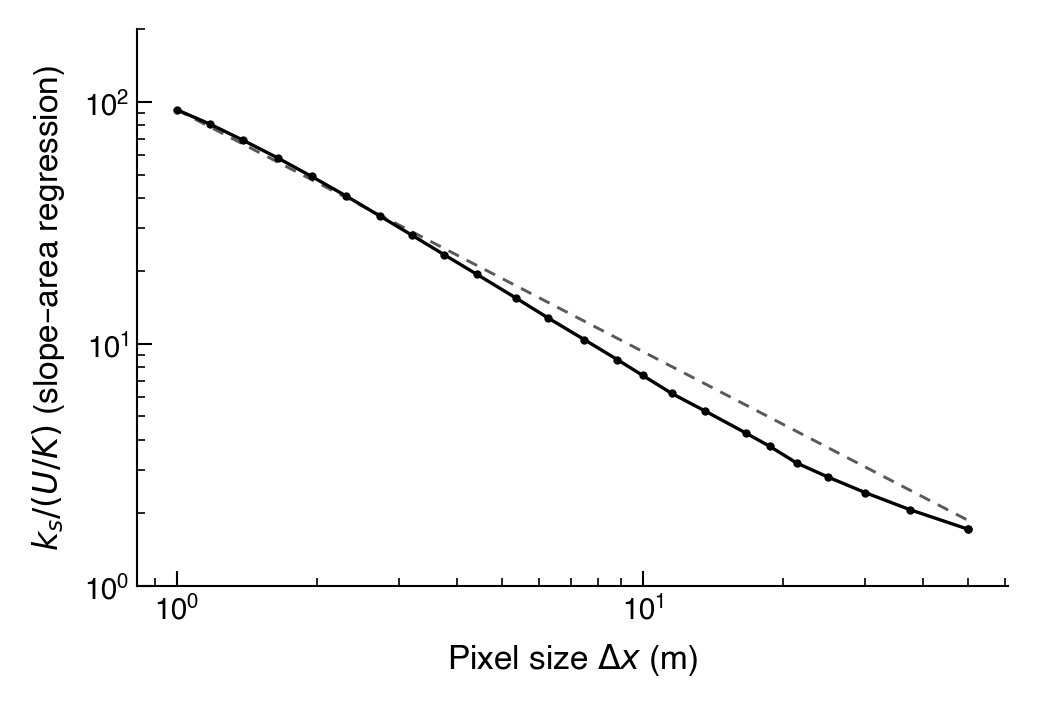

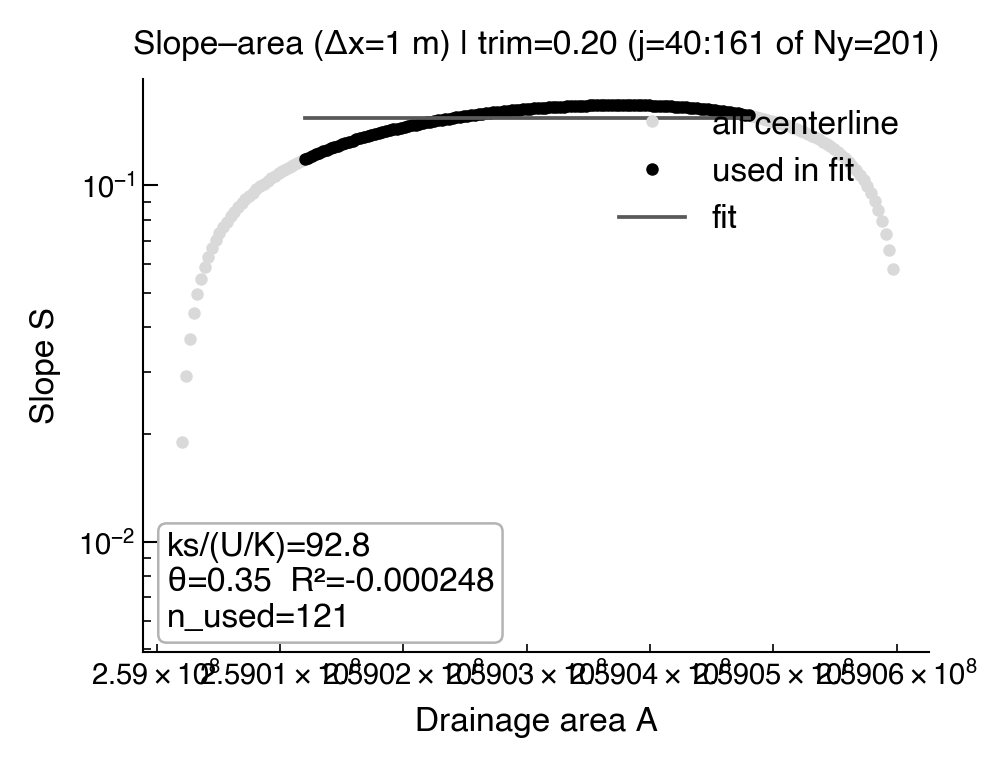

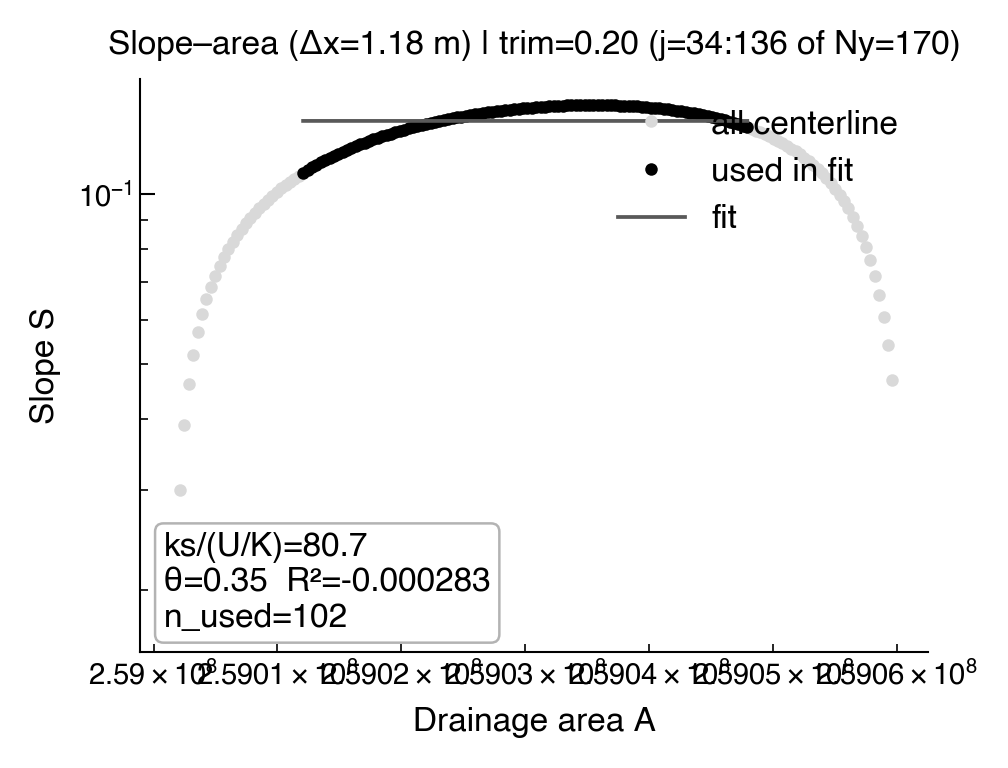

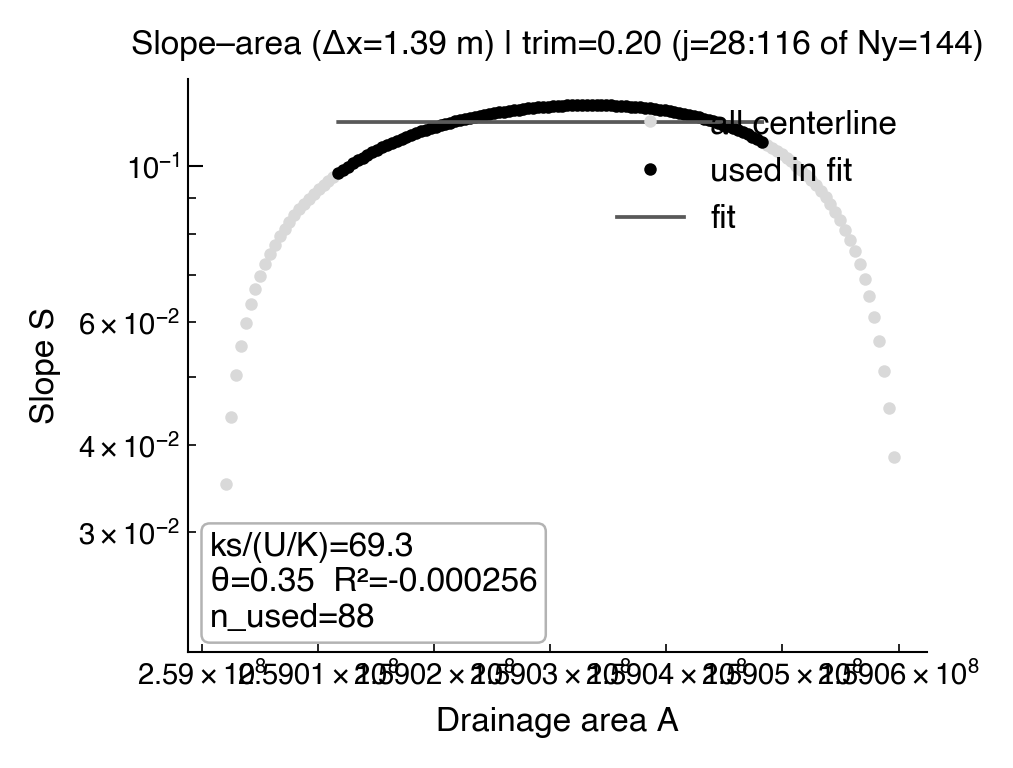

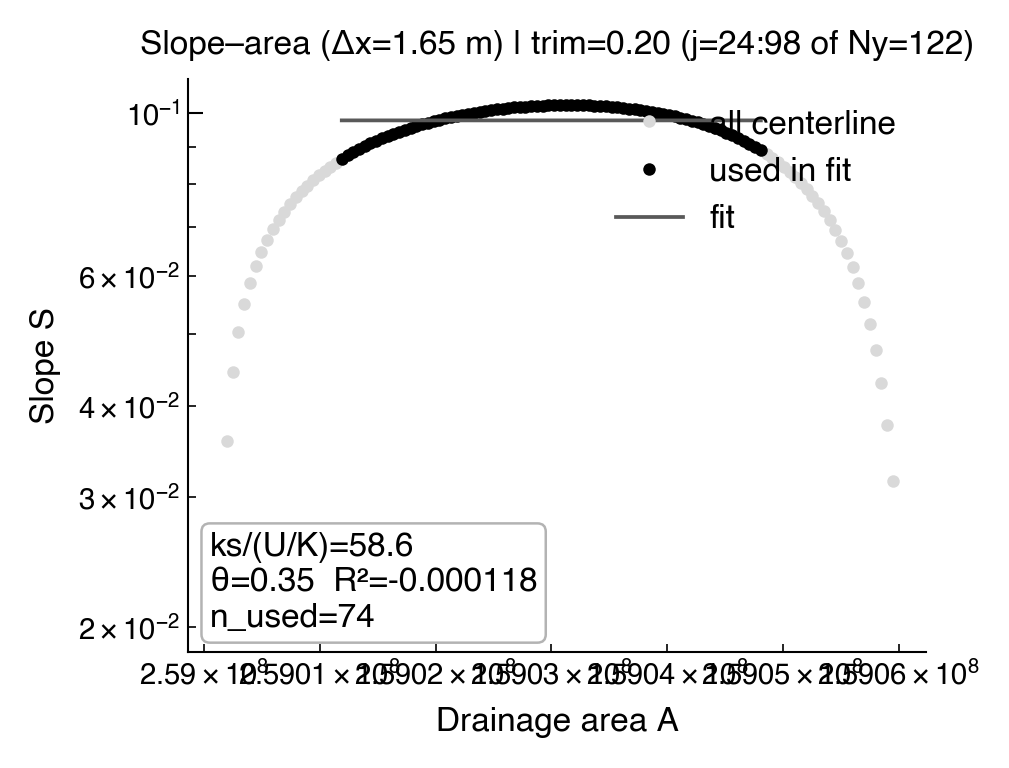

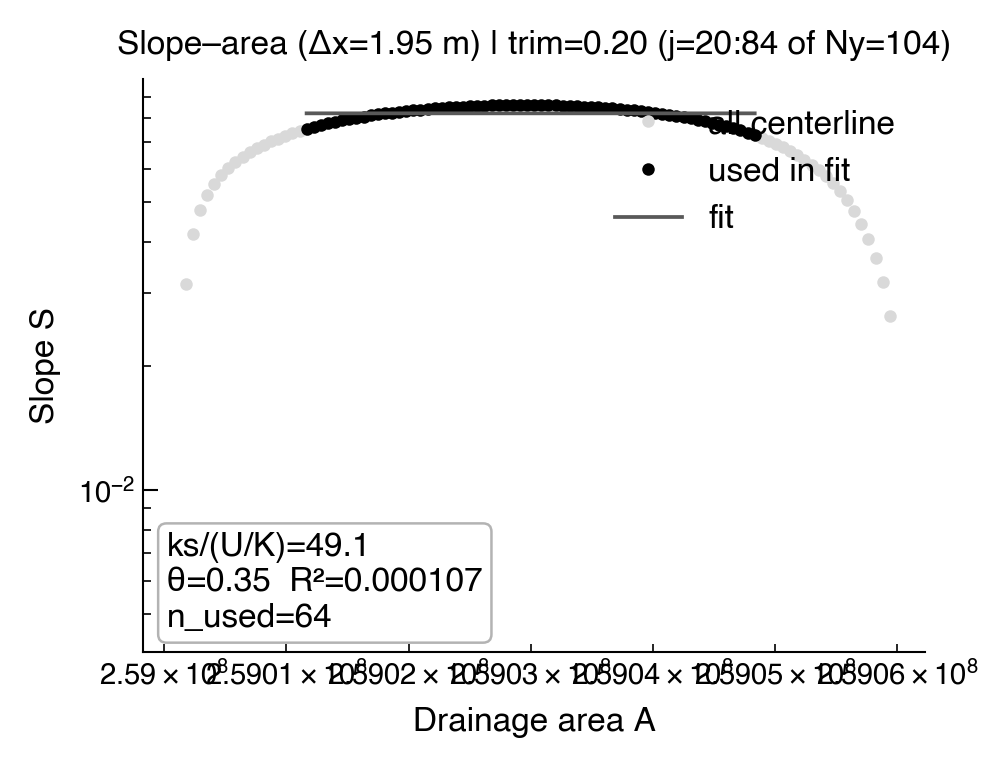

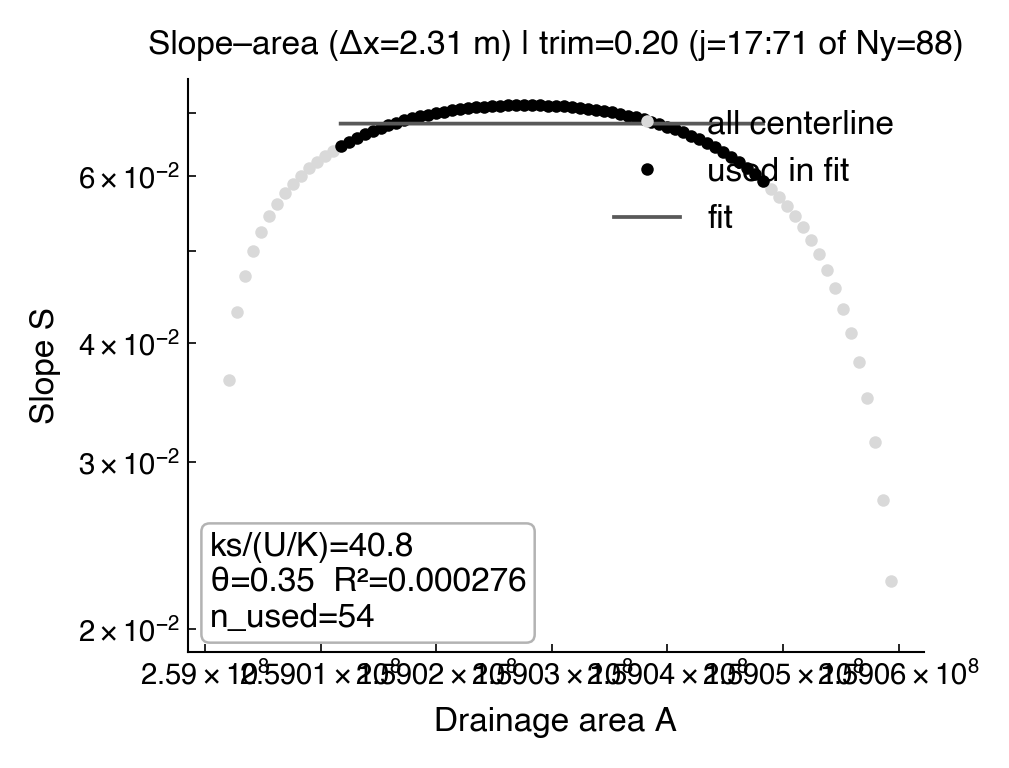

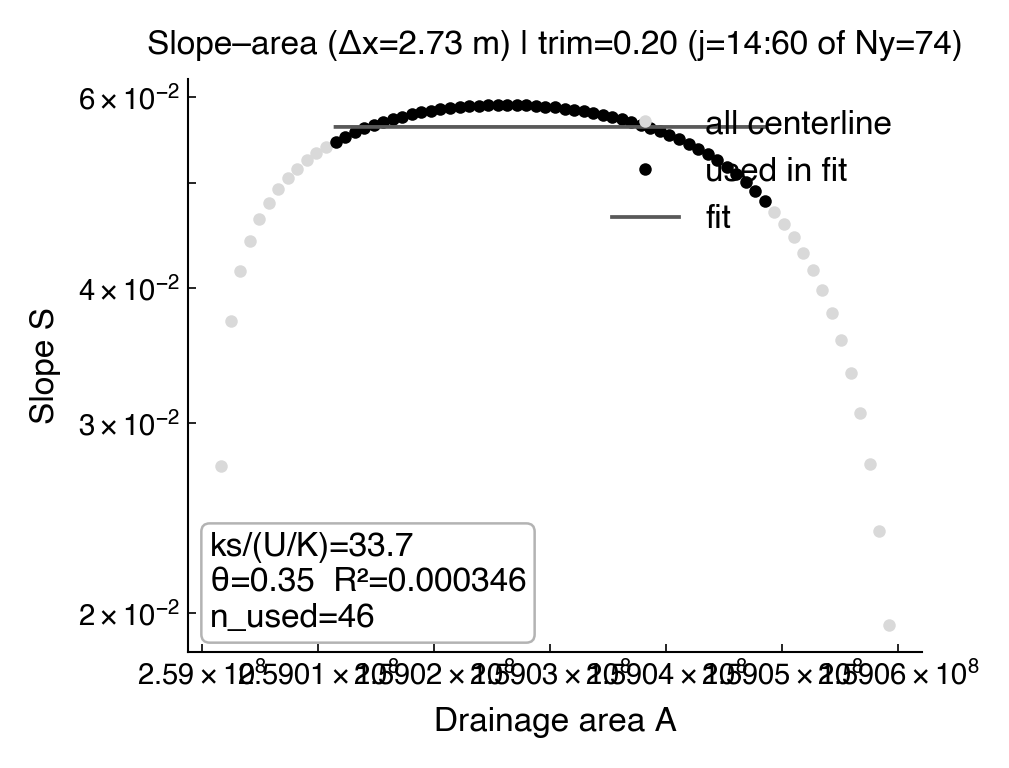

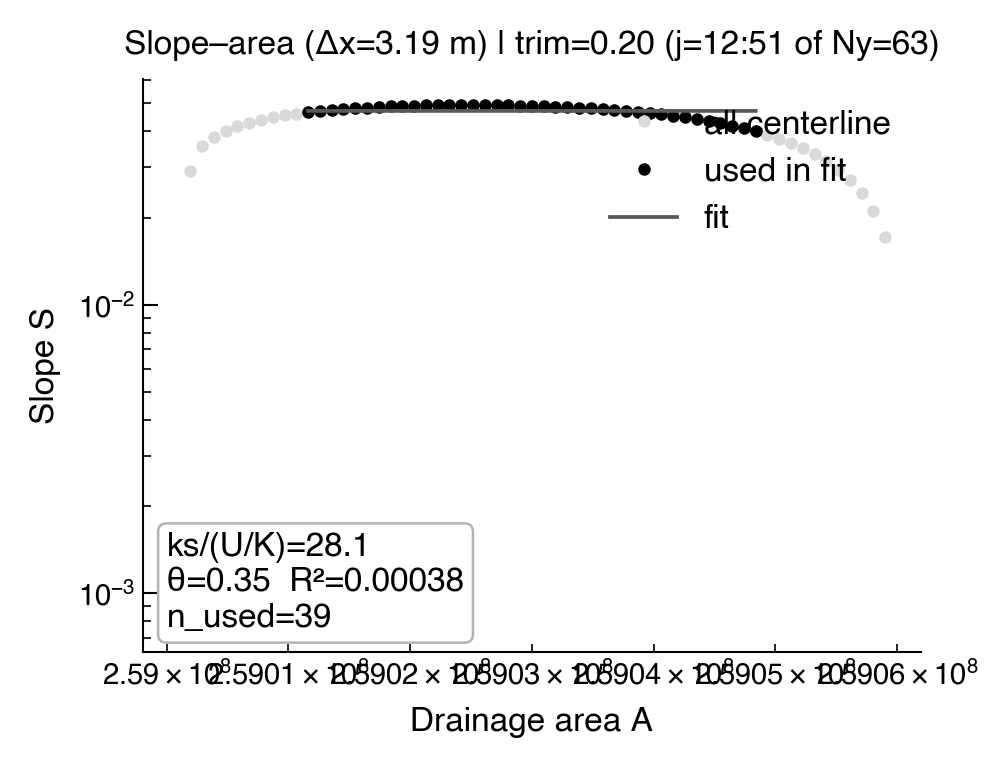

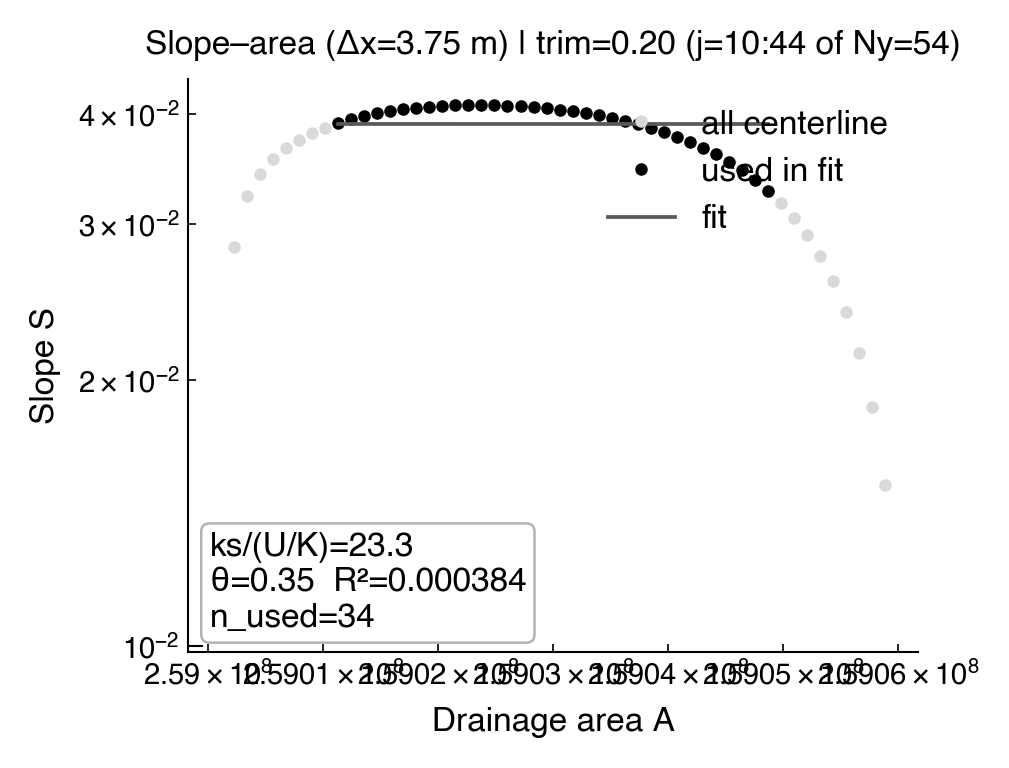

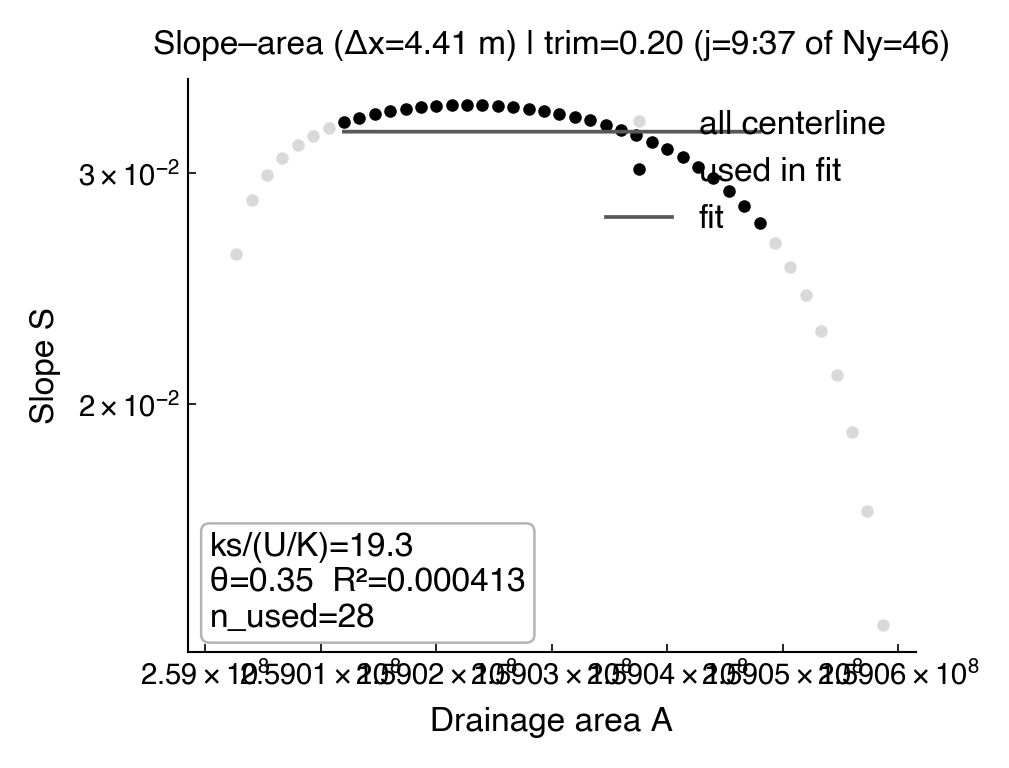

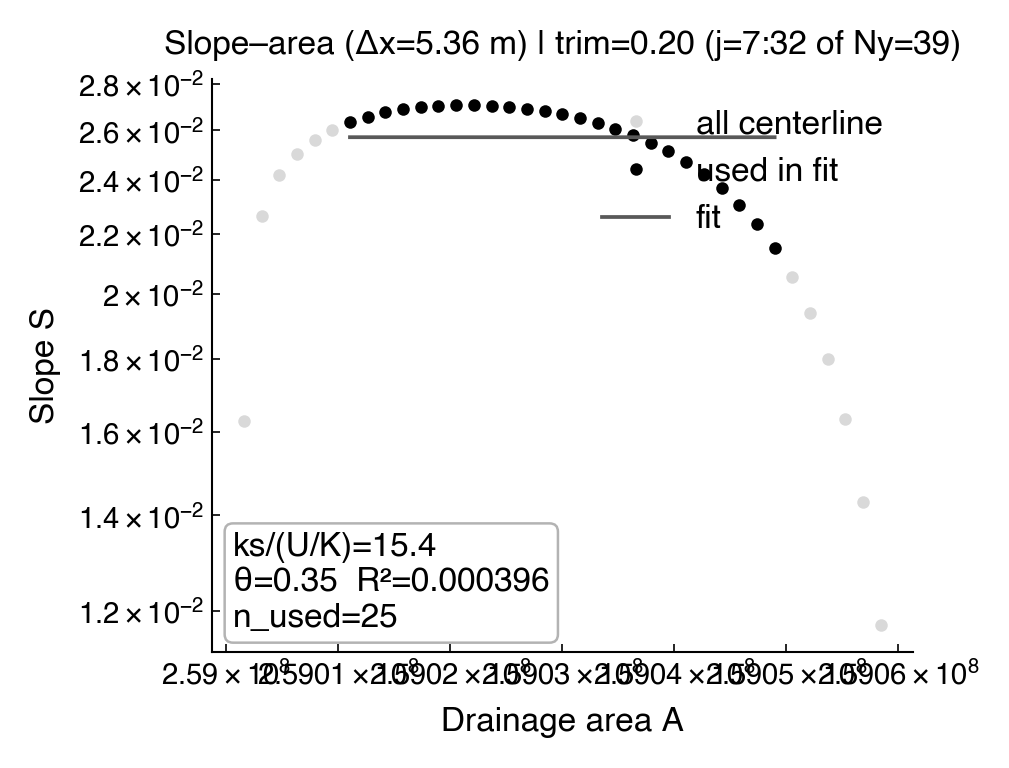

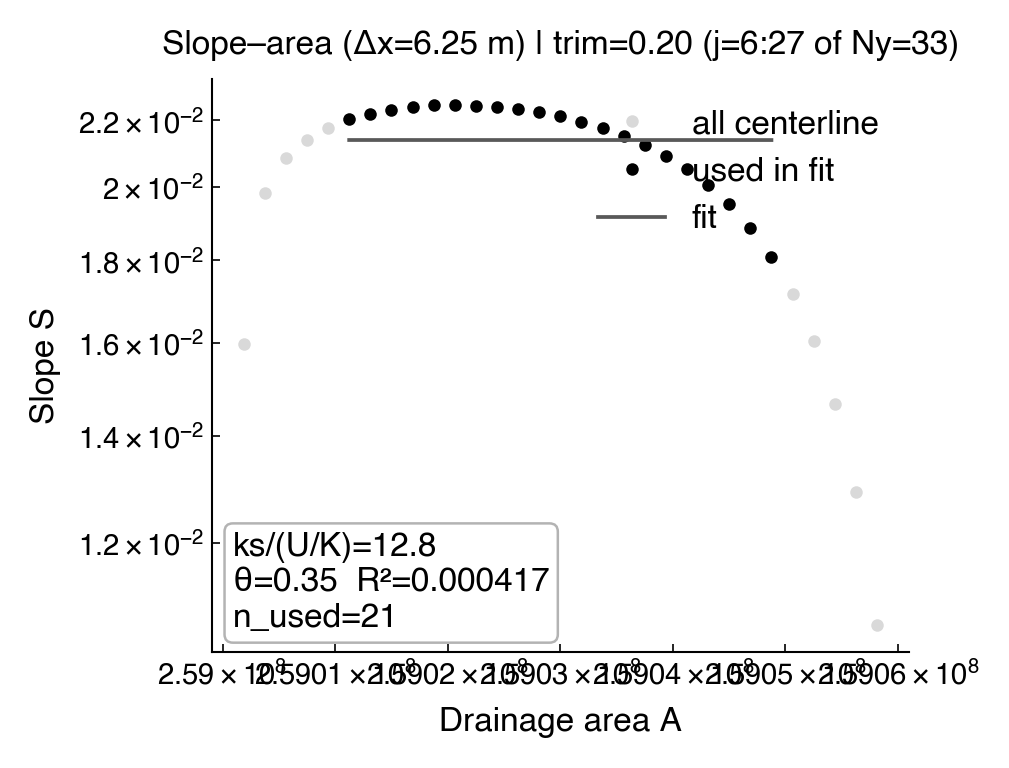

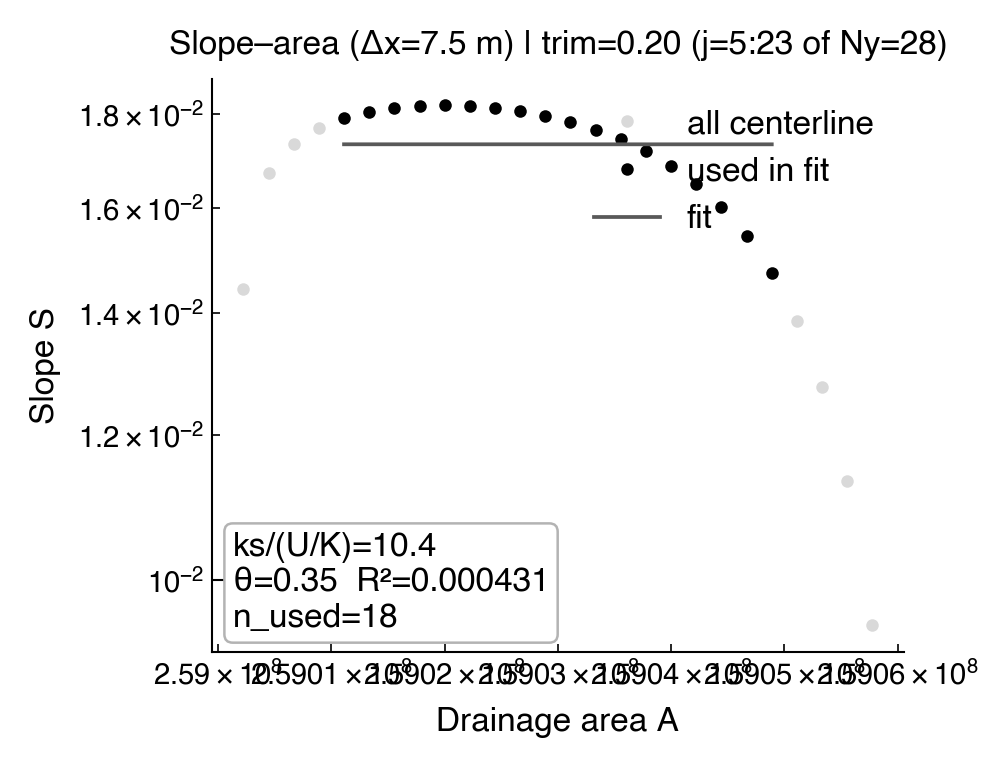

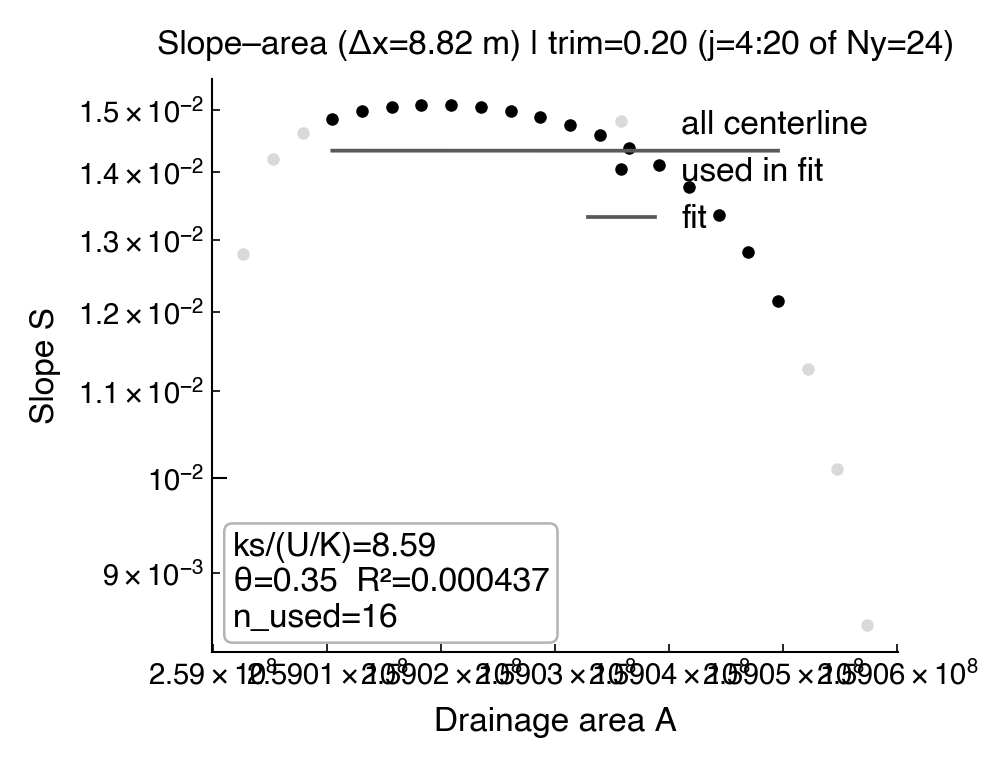

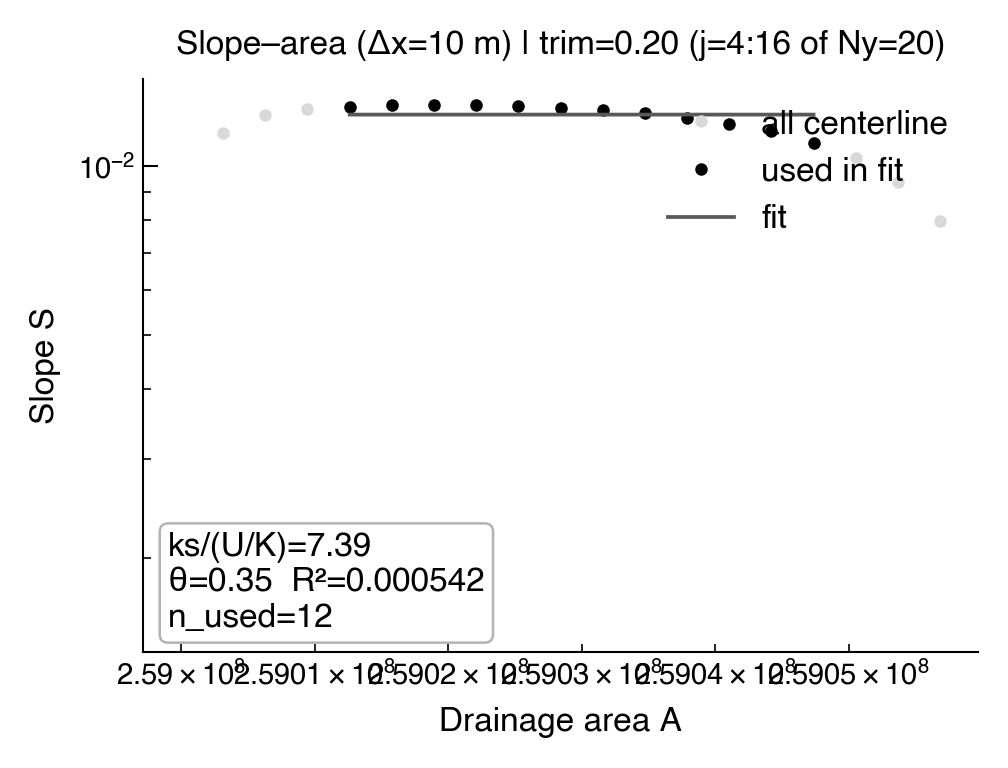

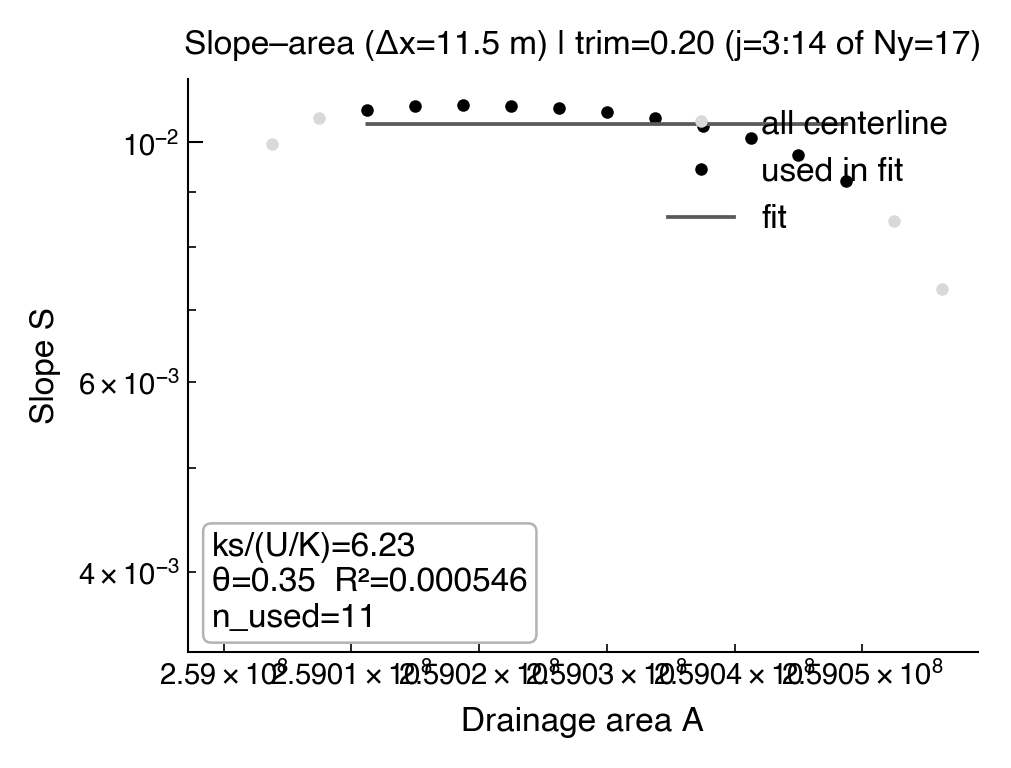

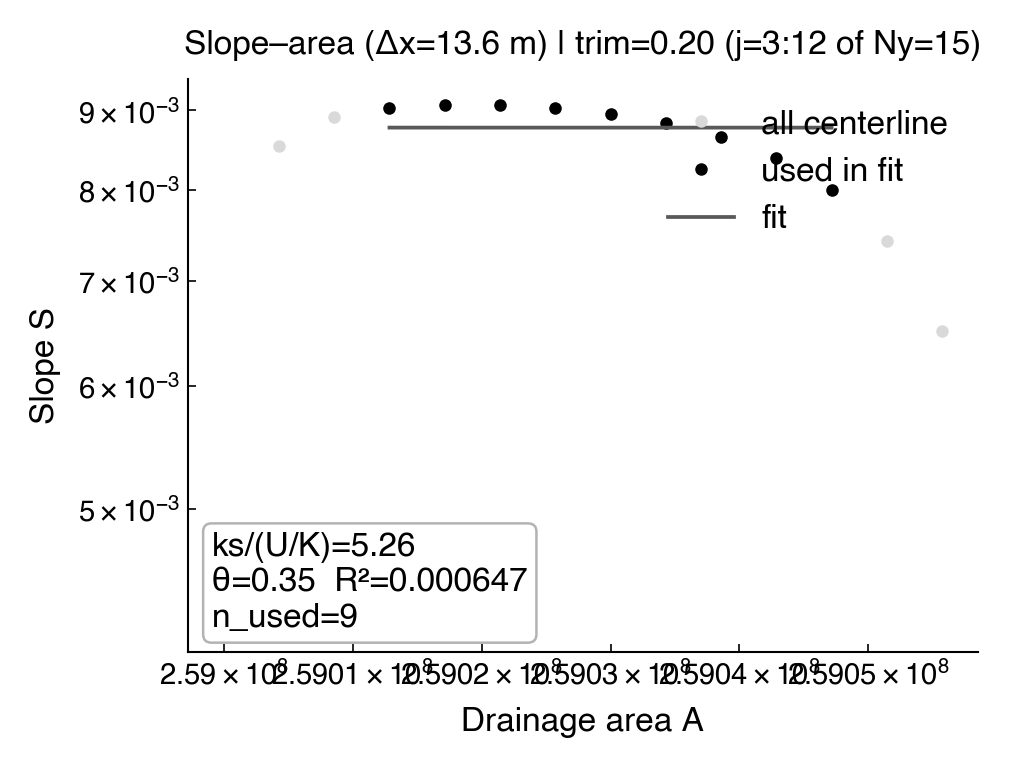

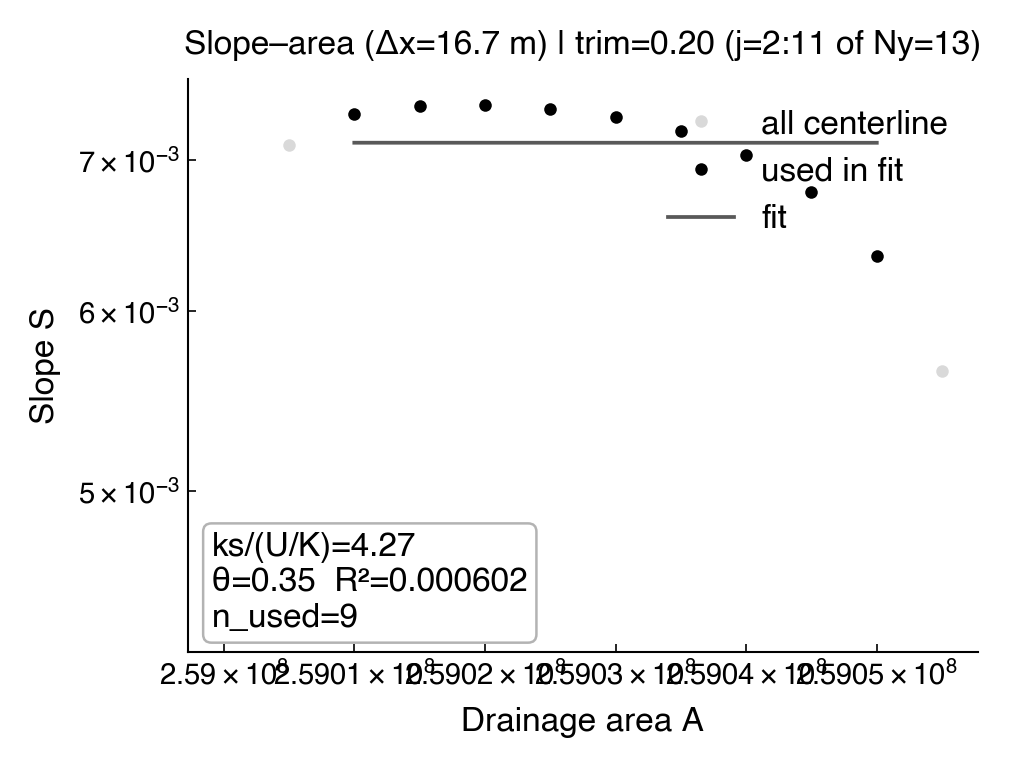

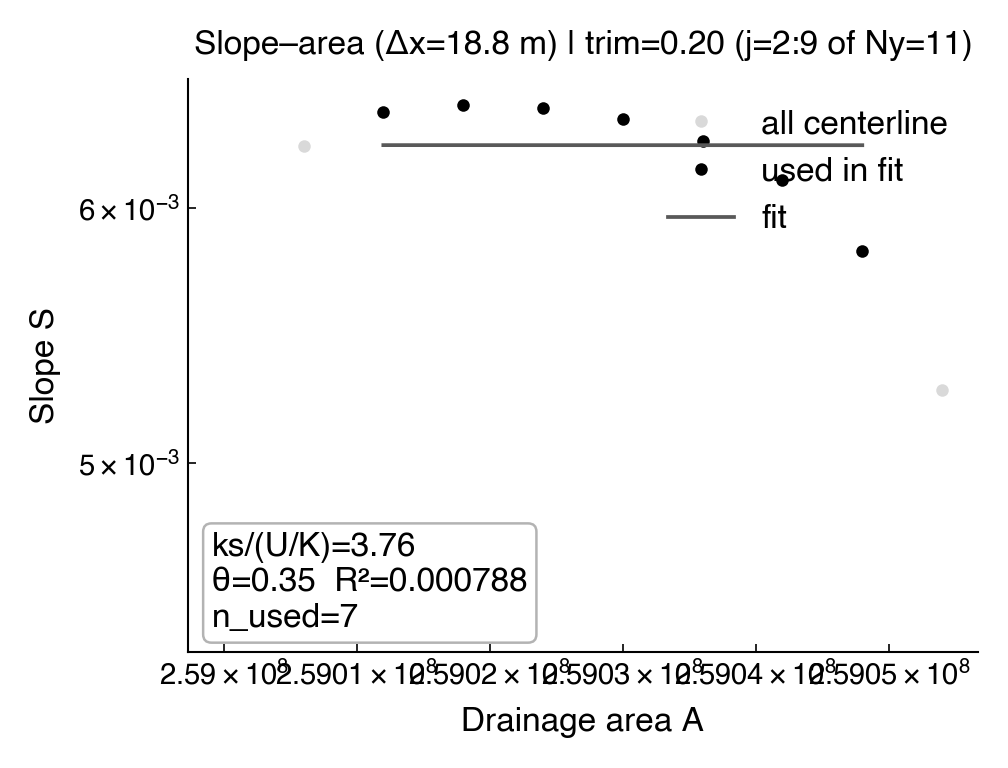

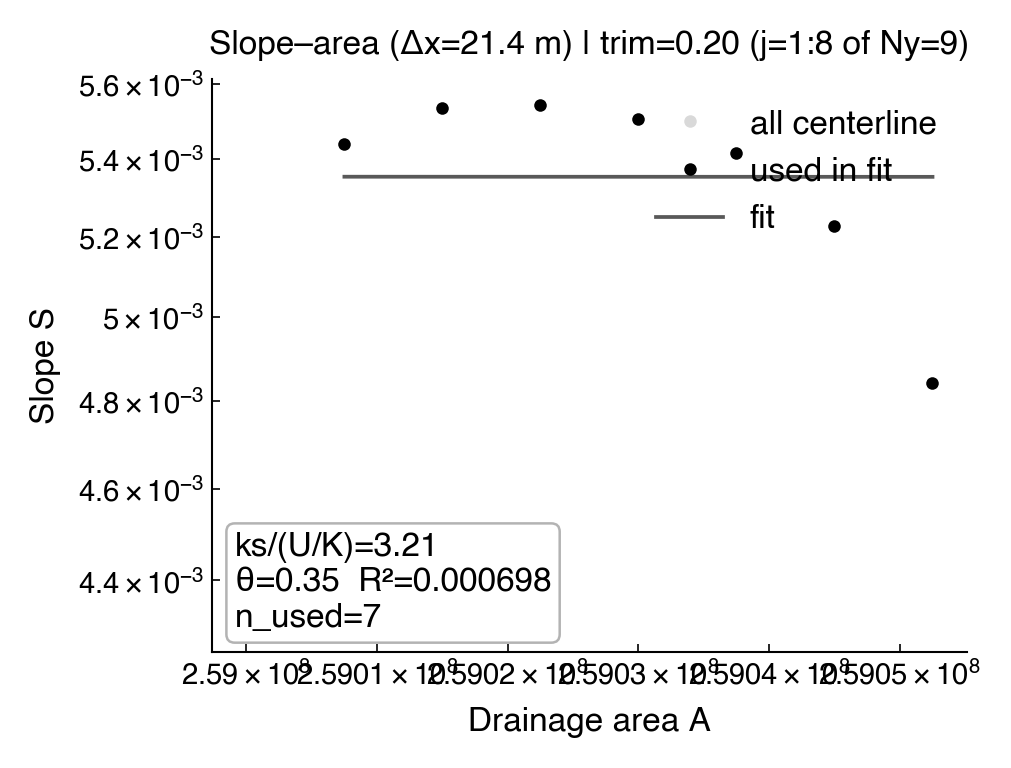

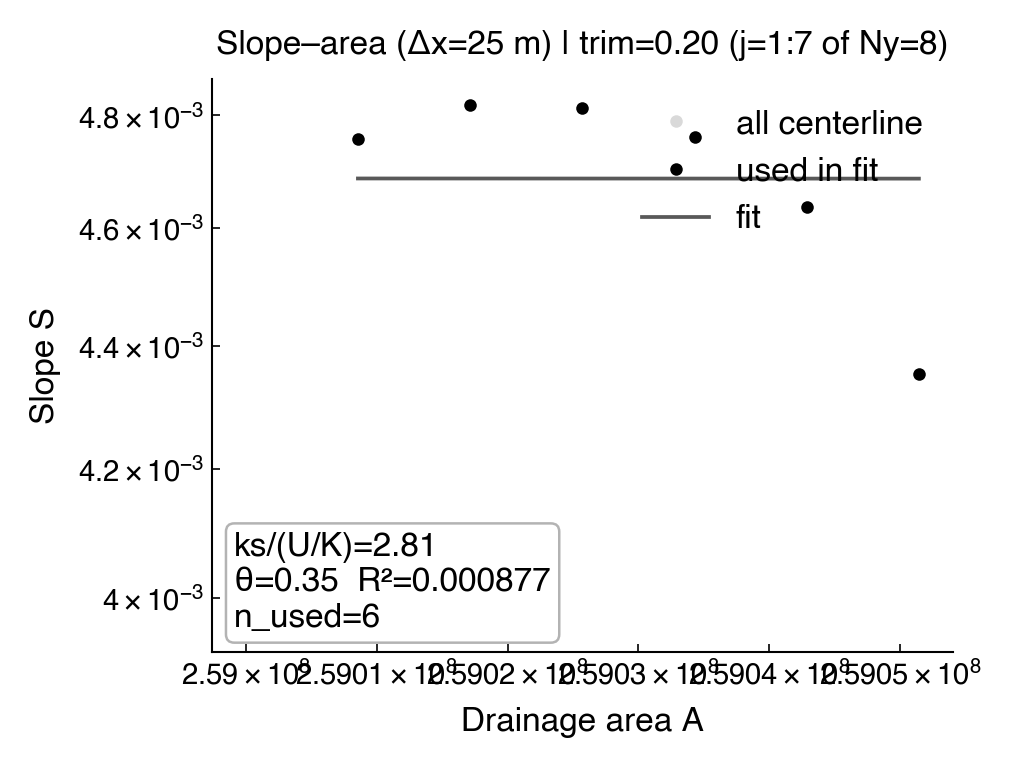

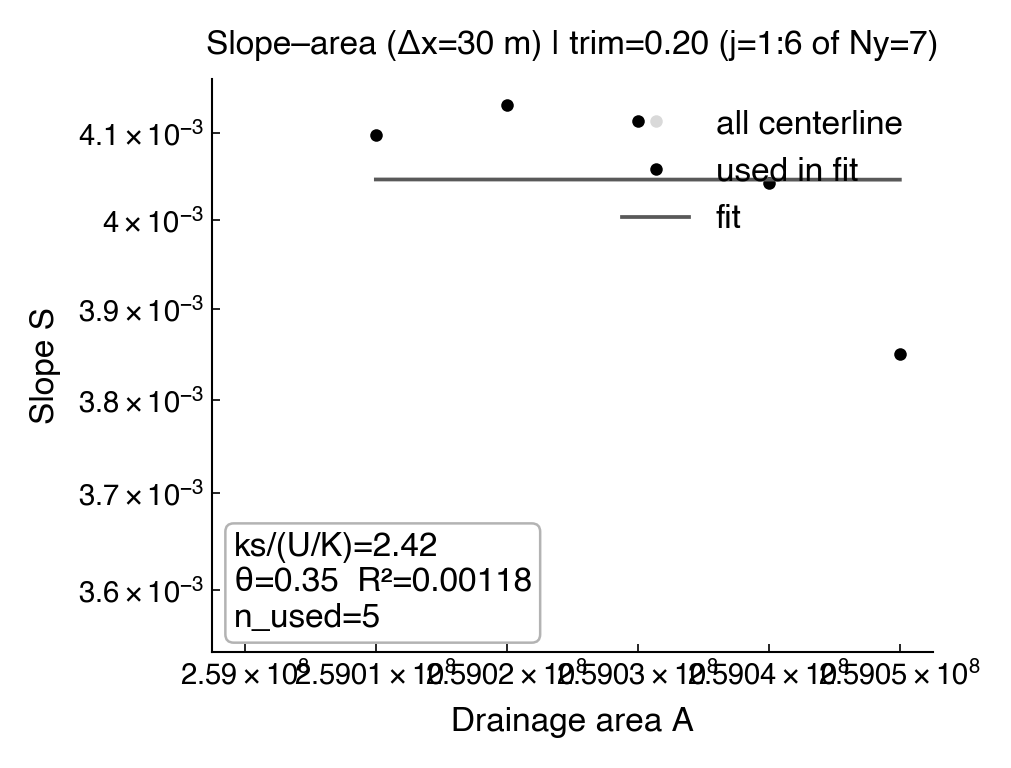

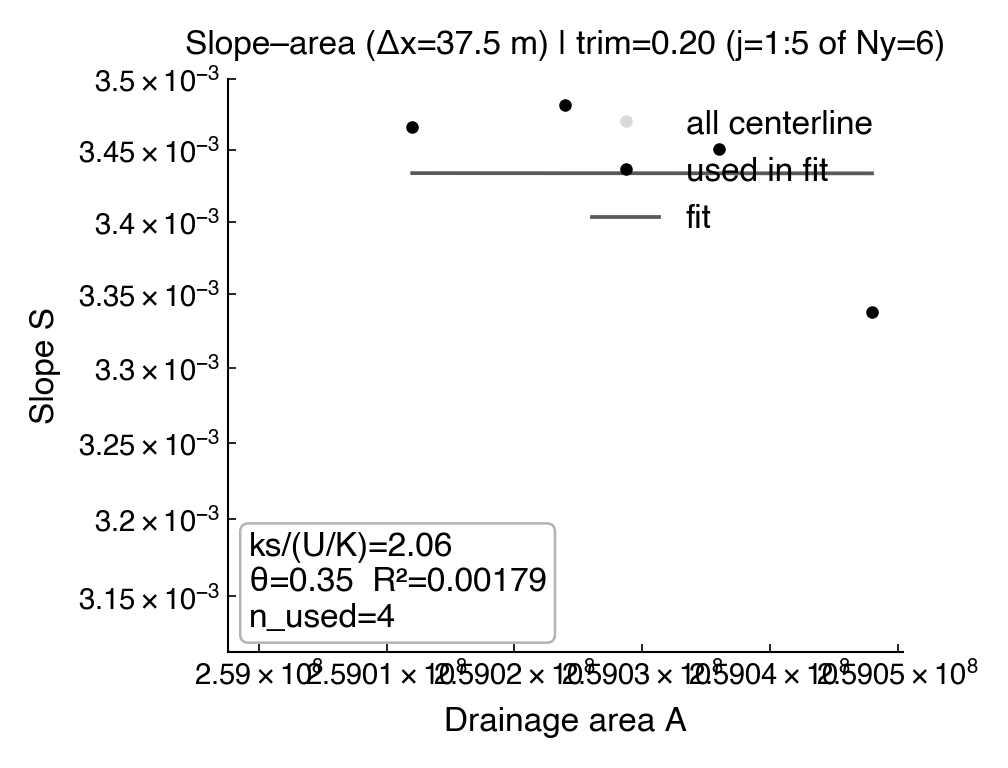

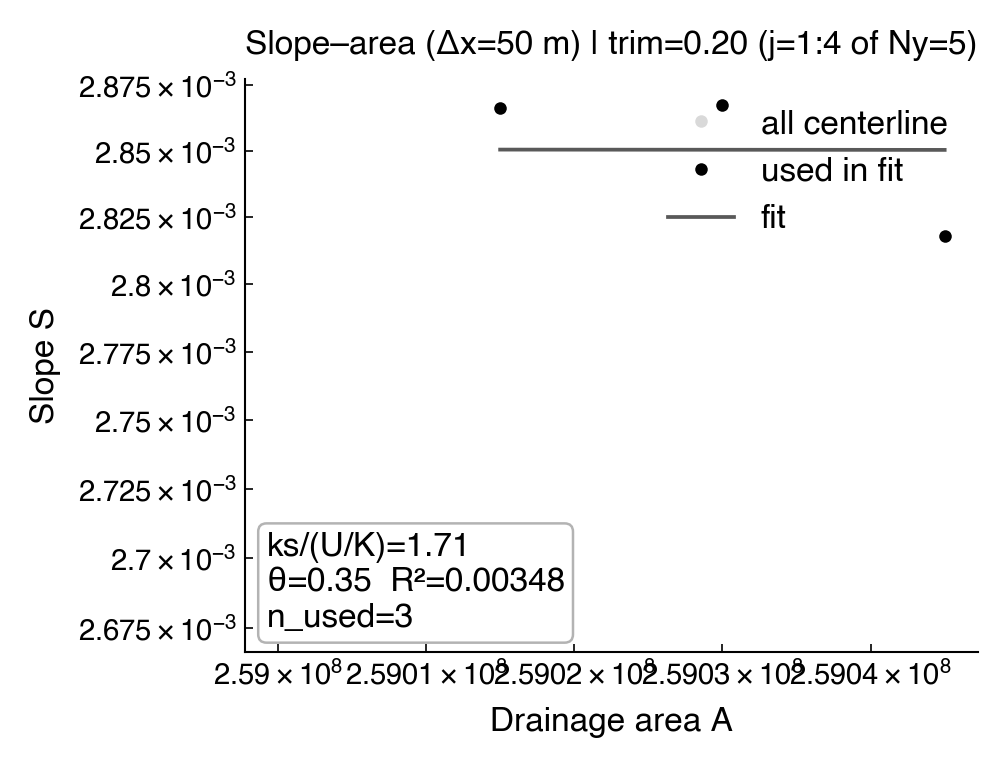

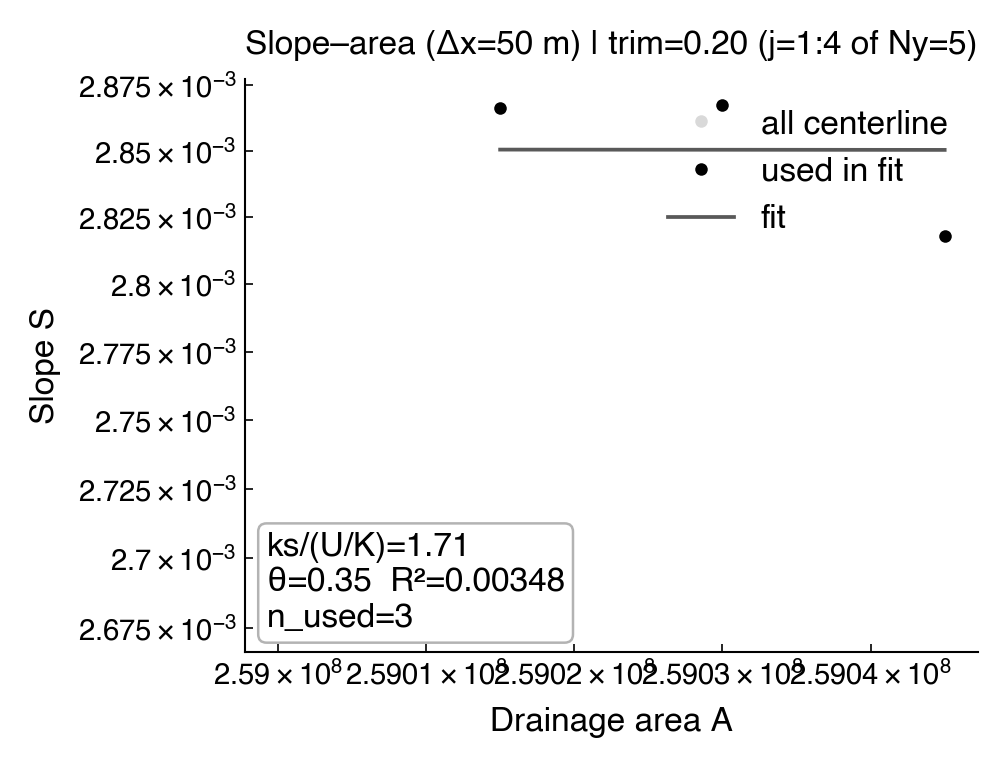


Trim bookkeeping:
dx=1  Ny=201  trim=0.20  j=40:161  n_used=121
dx=1.18  Ny=170  trim=0.20  j=34:136  n_used=102
dx=1.39  Ny=144  trim=0.20  j=28:116  n_used=88
dx=1.65  Ny=122  trim=0.20  j=24:98  n_used=74
dx=1.95  Ny=104  trim=0.20  j=20:84  n_used=64
dx=2.31  Ny=88  trim=0.20  j=17:71  n_used=54
dx=2.73  Ny=74  trim=0.20  j=14:60  n_used=46
dx=3.19  Ny=63  trim=0.20  j=12:51  n_used=39
dx=3.75  Ny=54  trim=0.20  j=10:44  n_used=34
dx=4.41  Ny=46  trim=0.20  j=9:37  n_used=28
dx=5.36  Ny=39  trim=0.20  j=7:32  n_used=25
dx=6.25  Ny=33  trim=0.20  j=6:27  n_used=21
dx=7.5  Ny=28  trim=0.20  j=5:23  n_used=18
dx=8.82  Ny=24  trim=0.20  j=4:20  n_used=16
dx=10  Ny=20  trim=0.20  j=4:16  n_used=12
dx=11.5  Ny=17  trim=0.20  j=3:14  n_used=11
dx=13.6  Ny=15  trim=0.20  j=3:12  n_used=9
dx=16.7  Ny=13  trim=0.20  j=2:11  n_used=9
dx=18.8  Ny=11  trim=0.20  j=2:9  n_used=7
dx=21.4  Ny=9  trim=0.20  j=1:8  n_used=7
dx=25  Ny=8  trim=0.20  j=1:7  n_used=6
dx=30  Ny=7  trim=0.20  j=1:6  n_us

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import os

# -----------------------
# USER PARAMS
# -----------------------
Lx, Ly = 300.0, 200.0
U = 1.47e-4
K = 1.0e-4
m = 0.35

L_PE = 50.0
PE_BAL = 100.0

BASELINE_MODE = "A_INLET"   # "A_INLET" or "D"
A_INLET_BAL_ANCHOR = 2.59e8
D_BAL_ANCHOR       = 4.4e-2

dx_targets = np.logspace(np.log10(55.0), np.log10(1.0), 25)[::-1]
FRAC_TRIM = 0.2

PRIMARY_FACTOR = 1.0

# Reference scale
ks_ref = U / K

# Regression settings
THETA_MODE = "fixed"     # "fixed" or "free"
MIN_POINTS = 3           # allow coarse grids; set to 5 to be strict

# -----------------------
# Matplotlib style
# -----------------------
set_nature_style()

# ============================================================
# Compute curve + collect slope–area regression data (UNAMBIGUOUS TRIM)
# ============================================================
def compute_curve_and_collect(D_use, A_inlet_target, theta_mode="fixed", min_points=5, frac_trim=0.2):
    records = []

    for dx_t in dx_targets:
        Nx = int(round(Lx / dx_t)) + 1
        Ny = int(round(Ly / dx_t)) + 1
        if Nx % 2 == 0:
            Nx += 1

        A_top_use = A_top_for_target_inlet_area(Nx, Ny, Lx, Ly, A_inlet_target)

        Z, A, dx, dy = solve_advection_diffusion_planform_noflux(
            U=U, K=K, m=m, D=D_use,
            Nx=Nx, Ny=Ny, Lx=Lx, Ly=Ly, A_top=A_top_use
        )

        ic = (Nx - 1) // 2

        # FULL centerline arrays (untrimmed)
        A_all = A[:, ic].copy()
        S_all = channel_slope_centerline(Z, Nx, Ny, dx, dy)

        # explicit trim indices (unambiguous)
        j0, j1 = interior_slice_indices(Ny, frac_trim)
        sl = slice(j0, j1)

        # the regression sees only this trimmed portion
        A_use = A_all[sl].copy()
        S_use = S_all[sl].copy()

        if theta_mode.lower() == "fixed":
            fit = fit_slope_area(A_use, S_use, theta_fixed=m, min_points=min_points)
        else:
            fit = fit_slope_area(A_use, S_use, theta_fixed=None, min_points=min_points)

        ks_est = fit["ks"]
        ks_norm = ks_est / ks_ref if np.isfinite(ks_est) else np.nan

        # boolean mask into FULL arrays for points used in the regression
        used_mask_trim = fit["used_mask"]
        used_mask_full = np.zeros(Ny, dtype=bool)
        used_mask_full[sl] = used_mask_trim

        rec = {
            "dx": float(dx),
            "Nx": int(Nx),
            "Ny": int(Ny),

            "ks": float(ks_est) if np.isfinite(ks_est) else np.nan,
            "ks_norm": float(ks_norm) if np.isfinite(ks_norm) else np.nan,
            "theta": float(fit["theta"]) if np.isfinite(fit["theta"]) else np.nan,
            "r2": float(fit["r2"]) if np.isfinite(fit["r2"]) else np.nan,
            "n_used": int(fit["n_good"]),

            # store full arrays + used mask so plots show excluded points too
            "A_all": A_all,
            "S_all": S_all,
            "used_mask_full": used_mask_full,

            # store trim bookkeeping explicitly
            "frac_trim": float(frac_trim),
            "j0": int(j0),
            "j1": int(j1),

            # regression-space arrays (for line plotting)
            "logA": fit["logA"],
            "logS": fit["logS"],
            "logS_pred": fit["logS_pred"],
        }
        records.append(rec)

    good = [r for r in records if np.isfinite(r["ks_norm"]) and (r["ks_norm"] > 0) and (r["dx"] > 0)]
    good_sorted = sorted(good, key=lambda r: r["dx"])

    dx_arr = np.array([r["dx"] for r in good_sorted], dtype=float)
    ks_arr = np.array([r["ks_norm"] for r in good_sorted], dtype=float)

    records_sorted = sorted(records, key=lambda r: r["dx"])
    return dx_arr, ks_arr, records_sorted

# ============================================================
# Plot slope–area individually (shows excluded vs used points)
# ============================================================
def plot_slope_area_individual(records, theta_mode="fixed", out_dir=None, show=True, max_plots=None):
    if out_dir is not None:
        os.makedirs(out_dir, exist_ok=True)

    n_done = 0
    for rec in records:
        if (max_plots is not None) and (n_done >= max_plots):
            break

        dx = rec["dx"]
        Ny = rec["Ny"]
        A_all = rec["A_all"]
        S_all = rec["S_all"]
        used = rec["used_mask_full"]
        j0, j1 = rec["j0"], rec["j1"]

        fig, ax = plt.subplots(figsize=(3.4, 2.6))

        # ALL centerline points (including trimmed-out) in light gray
        mask_all = np.isfinite(A_all) & np.isfinite(S_all) & (A_all > 0) & (S_all > 0)
        if mask_all.any():
            ax.loglog(
                A_all[mask_all], S_all[mask_all], "o",
                ms=3.0, mfc="0.85", mec="0.85", mew=0.0, lw=0.0,
                label="all centerline"
            )

        # USED points (after trim + mask) in black
        if used.any():
            ax.loglog(
                A_all[used], S_all[used], "o",
                ms=3.0, mfc="0.0", mec="0.0", mew=0.0, lw=0.0,
                label="used in fit"
            )

        # Fitted line
        logA = rec["logA"]
        logS_pred = rec["logS_pred"]
        if (logA is not None) and (logS_pred is not None) and (len(logA) > 0):
            order = np.argsort(logA)
            ax.loglog(10**logA[order], 10**logS_pred[order], "-", lw=0.9, color="0.35", label="fit")

        # Annotation (explicit about trim)
        ks_txt = rec["ks_norm"]
        theta_txt = rec["theta"]
        r2_txt = rec["r2"]
        n_used = rec["n_used"]
        frac_trim = rec["frac_trim"]

        ax.set_title(f"Slope–area (Δx={dx:.3g} m) | trim={frac_trim:.2f} (j={j0}:{j1} of Ny={Ny})")

        if np.isfinite(ks_txt):
            txt = (f"ks/(U/K)={ks_txt:.3g}\n"
                   f"θ={theta_txt:.3g}  R²={r2_txt:.3g}\n"
                   f"n_used={n_used:d}")
        else:
            txt = f"insufficient data\nn_used={n_used:d}"

        ax.text(
            0.03, 0.03, txt, transform=ax.transAxes,
            ha="left", va="bottom", fontsize=8,
            bbox=dict(boxstyle="round,pad=0.25", fc="1.0", ec="0.7", lw=0.6)
        )

        ax.set_xlabel("Drainage area A")
        ax.set_ylabel("Slope S")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.xaxis.set_major_locator(LogLocator(base=10))
        ax.yaxis.set_major_locator(LogLocator(base=10))
        ax.tick_params(which="both", pad=2)
        ax.legend(frameon=False, loc="upper right", fontsize=8)

        fig.tight_layout()

        if out_dir is not None:
            fname = f"slope_area_dx_{dx:.3g}m.png".replace(".", "p")
            fig.savefig(os.path.join(out_dir, fname), dpi=300)

        if show:
            plt.show()
        else:
            plt.close(fig)

        n_done += 1

# ============================================================
# Main: Peclet-consistent baseline
# ============================================================
if BASELINE_MODE.upper() == "A_INLET":
    A_inlet_bal = float(A_INLET_BAL_ANCHOR)
    D_bal = D_from_Pe(PE_BAL, A_inlet_bal, K, L_PE, m)
elif BASELINE_MODE.upper() == "D":
    D_bal = float(D_BAL_ANCHOR)
    A_inlet_bal = inlet_area_from_Pe(PE_BAL, D_bal, K, L_PE, m)
else:
    raise ValueError("BASELINE_MODE must be 'A_INLET' or 'D'.")

D_primary = D_bal * PRIMARY_FACTOR
Pe_primary = Pe_from_D_Ain(D_primary, A_inlet_bal, K, L_PE, m)

print(f"[primary] Pe_bal={PE_BAL:g}, L_PE={L_PE:g} m -> D_bal={D_bal:.3e}, A_inlet_bal={A_inlet_bal:.3e}")
print(f"[primary] factor={PRIMARY_FACTOR:g} -> D={D_primary:.3e}, Pe={Pe_primary:.3g}")

# ============================================================
# Run: compute curve + records
# ============================================================
dx_arr, ks_arr, records = compute_curve_and_collect(
    D_use=D_primary,
    A_inlet_target=A_inlet_bal,
    theta_mode=THETA_MODE,
    min_points=MIN_POINTS,
    frac_trim=FRAC_TRIM
)

# ============================================================
# Plot: ks vs dx
# ============================================================
fig, ax = plt.subplots(figsize=(3.5, 2.4))

ax.plot(
    dx_arr, ks_arr,
    "-o",
    color="0.0",
    lw=0.8,
    ms=2.0,
    mfc="0.0",
    mec="0.0",
    mew=0.0,
    zorder=3,
)

# -1 slope reference line (anchored to finest-resolution point)
dx0 = dx_arr[0]
ks0 = ks_arr[0]
dx_ref = np.array([dx_arr.min(), dx_arr.max()])
ks_ref_line = ks0 * (dx_ref / dx0) ** (-1.0)

ax.plot(
    dx_ref, ks_ref_line,
    "--",
    color="0.35",
    lw=0.7,
    dashes=(4, 3),
    zorder=1,
)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"Pixel size $\Delta x$ (m)")
ax.set_ylabel(r"$k_s/(U/K)$ (slope–area regression)")
ax.set_ylim(1e0, 2e2)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.xaxis.set_major_locator(LogLocator(base=10))
ax.yaxis.set_major_locator(LogLocator(base=10))
ax.tick_params(which="both", pad=2)

fig.tight_layout()
plt.show()

# ============================================================
# Plot: individual slope–area plots (unambiguous trim)
# ============================================================
plot_slope_area_individual(
    records,
    theta_mode=THETA_MODE,
    out_dir=None,   # set to "slope_area_plots" to save PNGs
    show=True
)

# Optional: quick console check of trim ranges
print("\nTrim bookkeeping:")
for r in records:
    print(f"dx={r['dx']:.3g}  Ny={r['Ny']}  trim={r['frac_trim']:.2f}  j={r['j0']}:{r['j1']}  n_used={r['n_used']}")

[primary] Pe_bal=100, L_PE=50 m -> D_bal=4.402e-02, A_inlet_bal=2.590e+08
[primary] factor=1 -> D=4.402e-02, Pe=100


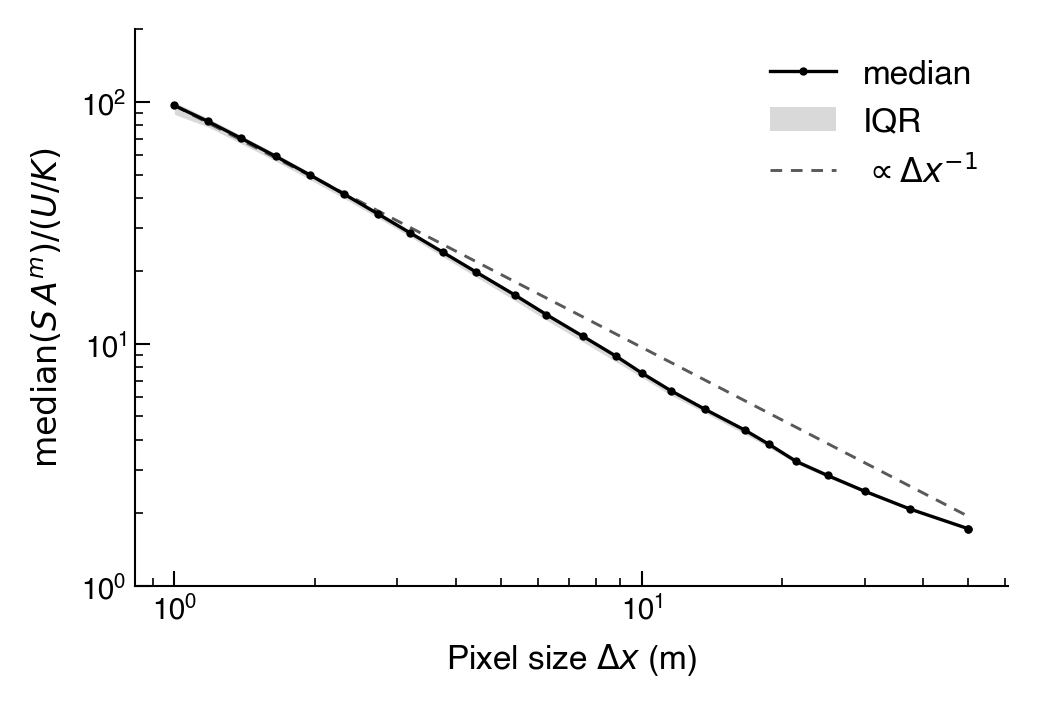


Summary (sorted by dx):
dx=1  Ny=201  n_good=121  median ks/(U/K)=96.6  IQR=[88.8, 99.7]
dx=1.18  Ny=170  n_good=102  median ks/(U/K)=82.9  IQR=[78.7, 85.3]
dx=1.39  Ny=144  n_good=88  median ks/(U/K)=70.7  IQR=[67.2, 72.7]
dx=1.65  Ny=122  n_good=74  median ks/(U/K)=59.5  IQR=[56.8, 61]
dx=1.95  Ny=104  n_good=64  median ks/(U/K)=49.9  IQR=[47.7, 51.1]
dx=2.31  Ny=88  n_good=54  median ks/(U/K)=41.5  IQR=[39.9, 42.4]
dx=2.73  Ny=74  n_good=46  median ks/(U/K)=34.4  IQR=[33.1, 35.1]
dx=3.19  Ny=63  n_good=39  median ks/(U/K)=28.7  IQR=[27.7, 29.3]
dx=3.75  Ny=54  n_good=34  median ks/(U/K)=23.9  IQR=[22.9, 24.4]
dx=4.41  Ny=46  n_good=28  median ks/(U/K)=19.8  IQR=[18.9, 20.1]
dx=5.36  Ny=39  n_good=25  median ks/(U/K)=15.9  IQR=[15.1, 16.1]
dx=6.25  Ny=33  n_good=21  median ks/(U/K)=13.2  IQR=[12.5, 13.4]
dx=7.5  Ny=28  n_good=18  median ks/(U/K)=10.7  IQR=[10.1, 10.9]
dx=8.82  Ny=24  n_good=16  median ks/(U/K)=8.86  IQR=[8.4, 8.98]
dx=10  Ny=20  n_good=12  median ks/(U/K)=7.56  IQR=

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator

# -----------------------
# USER PARAMS
# -----------------------
Lx, Ly = 300.0, 200.0
U = 1.47e-4
K = 1.0e-4
m = 0.35

L_PE = 50.0
PE_BAL = 100.0

BASELINE_MODE = "A_INLET"   # "A_INLET" or "D"
A_INLET_BAL_ANCHOR = 2.59e8
D_BAL_ANCHOR       = 4.4e-2

dx_targets = np.logspace(np.log10(55.0), np.log10(1.0), 25)[::-1]

# trim centerline rows when computing summary statistics
FRAC_TRIM = 0.2

# Peclet scaling factor (keep 1.0 unless you want to sweep)
PRIMARY_FACTOR = 1.0

# Summary statistic choices
MIN_POINTS = 3  # allow coarse grids (Ny small)

# Reference scale
ks_ref = U / K

# -----------------------
# Matplotlib style
# -----------------------
set_nature_style()

# ============================================================
# Compute dx curve using local ks = S*A^m (no regression, no curvature)
# ============================================================
def compute_curve_local_ks(D_use, A_inlet_target):
    rows = []

    for dx_t in dx_targets:
        Nx = int(round(Lx / dx_t)) + 1
        Ny = int(round(Ly / dx_t)) + 1
        if Nx % 2 == 0:
            Nx += 1

        A_top_use = A_top_for_target_inlet_area(Nx, Ny, Lx, Ly, A_inlet_target)

        Z, A, dx, dy = solve_advection_diffusion_planform_noflux(
            U=U, K=K, m=m, D=D_use,
            Nx=Nx, Ny=Ny,
            Lx=Lx, Ly=Ly,
            A_top=A_top_use
        )

        ic = (Nx - 1) // 2
        sl = interior_slice(Ny, FRAC_TRIM)

        A_use = A[sl, ic].copy()
        S_use = channel_slope_centerline(Z, Nx, Ny, dx, dy)[sl]

        ks_local, mask, n_good, ks_med, ks_q25, ks_q75 = ks_local_from_SA(
            A_use, S_use, m=m, min_points=MIN_POINTS
        )

        rows.append({
            "dx": float(dx),
            "Nx": int(Nx),
            "Ny": int(Ny),
            "n_good": int(n_good),
            "ks_med": float(ks_med) if np.isfinite(ks_med) else np.nan,
            "ks_q25": float(ks_q25) if np.isfinite(ks_q25) else np.nan,
            "ks_q75": float(ks_q75) if np.isfinite(ks_q75) else np.nan,
        })

    # keep good rows
    good = [r for r in rows if np.isfinite(r["ks_med"]) and r["ks_med"] > 0 and r["dx"] > 0]
    good = sorted(good, key=lambda r: r["dx"])

    dx_arr = np.array([r["dx"] for r in good], dtype=float)
    ks_med_norm = np.array([r["ks_med"] / ks_ref for r in good], dtype=float)
    ks_q25_norm = np.array([r["ks_q25"] / ks_ref for r in good], dtype=float)
    ks_q75_norm = np.array([r["ks_q75"] / ks_ref for r in good], dtype=float)

    return dx_arr, ks_med_norm, ks_q25_norm, ks_q75_norm, rows

# ============================================================
# 1) Peclet-consistent baseline
# ============================================================
if BASELINE_MODE.upper() == "A_INLET":
    A_inlet_bal = float(A_INLET_BAL_ANCHOR)
    D_bal = D_from_Pe(PE_BAL, A_inlet_bal, K, L_PE, m)
elif BASELINE_MODE.upper() == "D":
    D_bal = float(D_BAL_ANCHOR)
    A_inlet_bal = inlet_area_from_Pe(PE_BAL, D_bal, K, L_PE, m)
else:
    raise ValueError("BASELINE_MODE must be 'A_INLET' or 'D'.")

D_primary = D_bal * PRIMARY_FACTOR
Pe_primary = Pe_from_D_Ain(D_primary, A_inlet_bal, K, L_PE, m)

print(f"[primary] Pe_bal={PE_BAL:g}, L_PE={L_PE:g} m -> "
      f"D_bal={D_bal:.3e}, A_inlet_bal={A_inlet_bal:.3e}")
print(f"[primary] factor={PRIMARY_FACTOR:g} -> D={D_primary:.3e}, Pe={Pe_primary:.3g}")

# ============================================================
# 2) Compute curve using ks_local = S*A^m (no regression, no curvature)
# ============================================================
dx_arr, ks_med_norm, ks_q25_norm, ks_q75_norm, all_rows = compute_curve_local_ks(
    D_use=D_primary,
    A_inlet_target=A_inlet_bal
)

# ============================================================
# 3) Plot: median (and IQR) of ks_local/(U/K) vs dx
# ============================================================
fig, ax = plt.subplots(figsize=(3.5, 2.4))

# median curve
ax.plot(
    dx_arr, ks_med_norm,
    "-o",
    color="0.0",
    lw=0.8,
    ms=2.0,
    mfc="0.0",
    mec="0.0",
    mew=0.0,
    zorder=3,
    label="median"
)

# IQR envelope (optional but helpful)
ax.fill_between(
    dx_arr, ks_q25_norm, ks_q75_norm,
    color="0.85",
    zorder=1,
    lw=0.0,
    label="IQR"
)

# -1 slope reference line (anchored to finest-resolution point)
dx0 = dx_arr[0]
y0 = ks_med_norm[0]
dx_ref = np.array([dx_arr.min(), dx_arr.max()])
y_ref = y0 * (dx_ref / dx0) ** (-1.0)

ax.plot(
    dx_ref, y_ref,
    "--",
    color="0.35",
    lw=0.7,
    dashes=(4, 3),
    zorder=2,
    label=r"$\propto \Delta x^{-1}$"
)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"Pixel size $\Delta x$ (m)")
ax.set_ylabel(r"$\mathrm{median}(S\,A^m)/(U/K)$")

ax.set_ylim(1e0, 2e2)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.xaxis.set_major_locator(LogLocator(base=10))
ax.yaxis.set_major_locator(LogLocator(base=10))
ax.tick_params(which="both", pad=2)

ax.legend(frameon=False, fontsize=8, loc="upper right")

fig.tight_layout()
plt.show()

# ============================================================
# (Optional) print a small table of results
# ============================================================
print("\nSummary (sorted by dx):")
for r in sorted([rr for rr in all_rows if np.isfinite(rr["ks_med"])], key=lambda rr: rr["dx"]):
    print(f"dx={r['dx']:.3g}  Ny={r['Ny']:d}  n_good={r['n_good']:d}  "
          f"median ks/(U/K)={(r['ks_med']/ks_ref):.3g}  "
          f"IQR=[{(r['ks_q25']/ks_ref):.3g}, {(r['ks_q75']/ks_ref):.3g}]")